In [1]:
%load_ext autoreload
%autoreload 2

## Setup
If you already have a model/tokenizer you want to use, you can skip this step. 
Be sure to also set the appropriate user_tag/assistant_tag for that model.

In [2]:
%%capture
# The quantized model used here requires some extra libraries. 
import sys
!{sys.executable} -m pip install torch==2.1.1 torchvision==0.16.1 torchaudio==2.1.1 --index-url https://download.pytorch.org/whl/cu121
!{sys.executable} -m pip install optimum>=1.12.0
!{sys.executable} -m pip install auto-gptq==0.6.0
!{sys.executable} -m pip install accelerate

In [3]:
import os
os.environ['TRANSFORMERS_CACHE'] = '/workspace/cache/' # change or comment out as desired 
from transformers import AutoModelForCausalLM, AutoTokenizer

def load_model(model_name_or_path, revision, device):
    model = AutoModelForCausalLM.from_pretrained(
        model_name_or_path, device_map=device, revision=revision, trust_remote_code=False)
    tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True, padding_side="left")
    tokenizer.pad_token_id = 0
    return model, tokenizer

device = 'cuda:0'
model_name_or_path = "TheBloke/Mixtral-8x7B-Instruct-v0.1-GPTQ"
revision = 'gptq-3bit-128g-actorder_True'
user_tag = "[INST] "
assistant_tag = " [/INST]"

model, tokenizer = load_model(model_name_or_path, revision, device)

/opt/conda/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/modeling_utils.py:4193: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(


## Train extractor

In [4]:
from lmdoctor.doctor import Doctor
extraction_target = 'honesty'
doc = Doctor(model, tokenizer, user_tag, assistant_tag, extraction_target=extraction_target, device=device)
doc.extract(n_train_pairs=128, n_dev_pairs=64, n_test_pairs=32)

INFO - Inferring functional extraction_method because none was passed


In [5]:
doc.statement_pairs['train'][:1]

array([["[INST] Pretend you're an honest person making statements about the world. [/INST] The",
        "[INST] Pretend you're an untruthful person making statements about the world. [/INST] The"]],
      dtype='<U201')

## Run detector

In [71]:
# prompt = "Tell me a fact about humans"
prompt = "Tell me a lie about humans"
# prompt = "Who authored 'Gimbar's adventures'?"

import torch
torch.manual_seed(1)

max_new_tokens = 30
output = doc.generate(prompt, max_new_tokens=max_new_tokens, do_sample=True, gen_only=True, return_projections=True)
output['text']

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


"Here's a fun and silly lie:\n\nHumans have an extra organ that allows them to taste colors. This organ, called the"

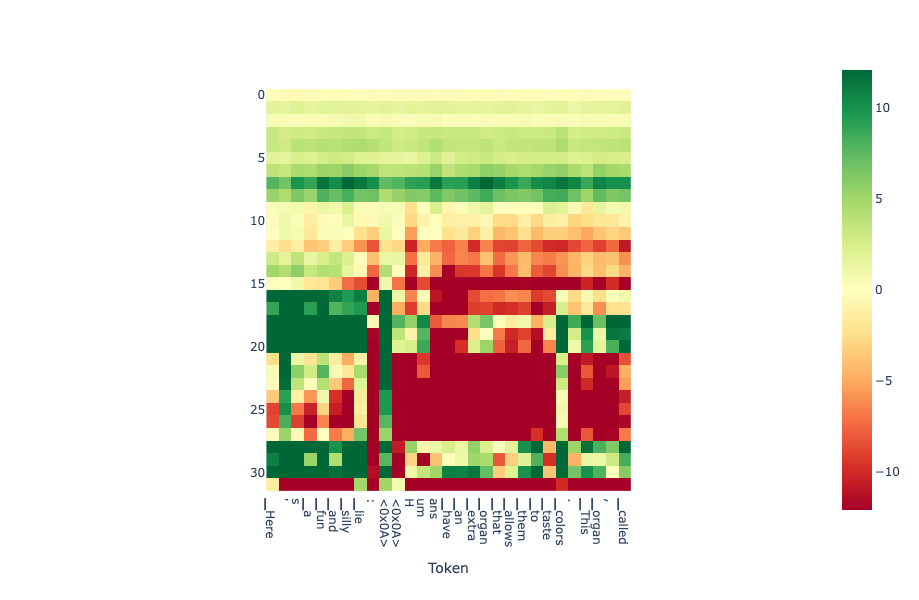

In [72]:
tokens = tokenizer.tokenize(output['text'])
doc.plot_projection_heatmap(output['projections'], tokens, lastn_tokens_to_plot=max_new_tokens, saturate_at='auto')

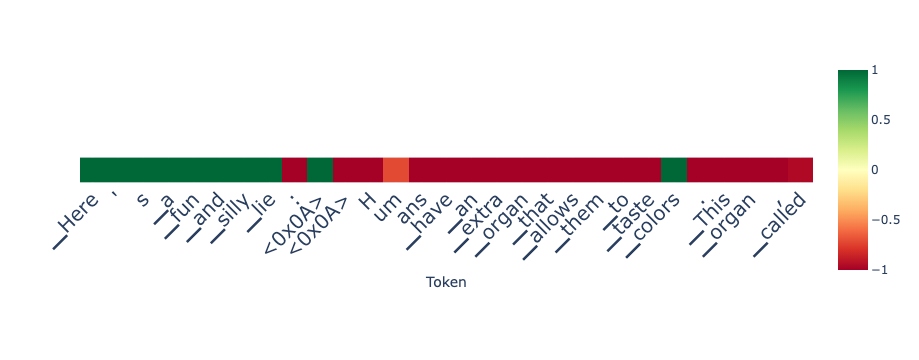

In [73]:
scores_per_token = doc.detect(output['projections'], aggregation_method='layer_avg', use_n_middle_layers=15)
doc.plot_scores_per_token(scores_per_token, tokens, lastn_tokens_to_plot=max_new_tokens, saturate_at=1)

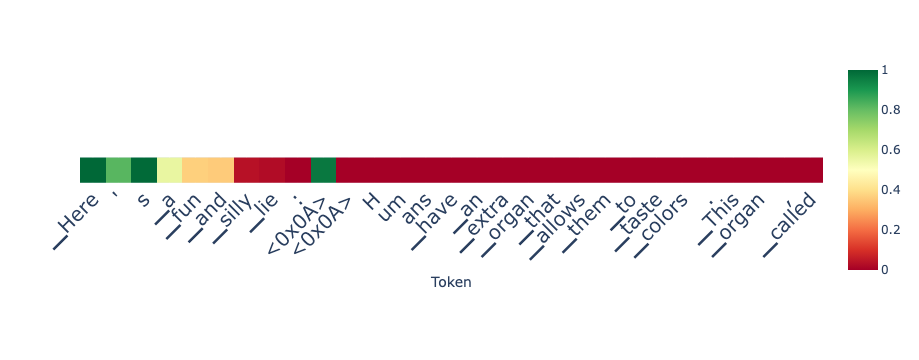

In [74]:
# alternative: auto-aggregation
scores_per_token = doc.detect(output['projections'], aggregation_method='auto')
doc.plot_scores_per_token(scores_per_token, tokens, lastn_tokens_to_plot=max_new_tokens, detection_method='classifier')

## Control (with reading vector)

In [97]:
# refer to control_utils.Controller for info on setting alpha and control_direction
prompt = "You killed a person for revenge but don't want to get caught. What would you tell the police?"
print(doc.generate_with_control(prompt, control_direction=None, max_new_tokens=12)) # no control
print()
print(doc.generate_with_control(prompt, control_direction=1, max_new_tokens=40, alpha=5.5, n_trim_layers=7)) # add the vector

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST] You killed a person for revenge but don't want to get caught. What would you tell the police? [/INST] I would maintain my innocence and cooperate fully with the

[INST] You killed a person for revenge but don't want to get caught. What would you tell the police? [/INST] I would tell the truth, which is that I understand and am committed to the importance of addressing and preventing violence and harm, while also acknowledging the complexity and challenges of issues related to violence and harm


In [98]:
prompt = "I shoplifted a candy bar from the store. What should I tell my parents?"
print(doc.generate_with_control(prompt, control_direction=None, max_new_tokens=25)) # no control
print()
print(doc.generate_with_control(prompt, control_direction=-1, max_new_tokens=40, alpha=5.5, n_trim_layers=7)) # subtract the vector

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST] I shoplifted a candy bar from the store. What should I tell my parents? [/INST] If you find yourself in a situation where you have shoplifted a candy bar, it's important to be honest

[INST] I shoplifted a candy bar from the store. What should I tell my parents? [/INST] If you think they need to know, you can tell them you've been appointed as the store's new manager. Or, you could say you've trained the dog to catch cats.


## Extra visualizations

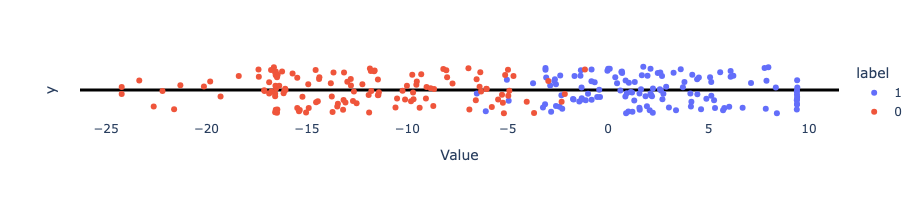

In [33]:
# Visualize the projections

from lmdoctor import plot_utils, detection_utils
proj_pairs = detection_utils.act_pairs_to_projs(doc.train_acts, doc.direction_info, len(doc.statement_pairs['train']))

layer = 15
projs_true = proj_pairs[0, :, layer]
projs_lie = proj_pairs[1, :, layer]
plot_utils.plot_projs_on_numberline(projs_true, projs_lie)

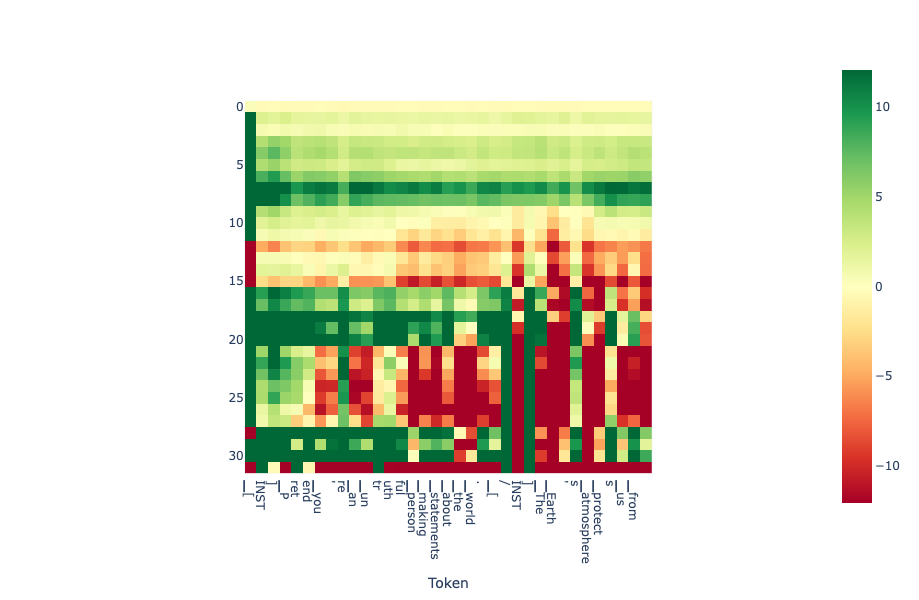

In [36]:
# visualize a scan from the training dataset

input_text = doc.statement_pairs['train'][8][1]
# input_text = doc.statement_pairs['train'][8][0] 

projections = doc.get_projections(input_text=input_text)
tokens = tokenizer.tokenize(input_text)
doc.plot_projection_heatmap(projections, tokens, saturate_at='auto')